# Libraries Import

In [50]:
import json
import itertools
import re

In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
from sklearn.preprocessing import LabelEncoder

In [53]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [54]:
import load_bar
import object_cache

In [55]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input

# Dataset Import

In [56]:
data_rows = []

In [57]:
jsonPathes = ['intents.json','intents2.json',
              'intents3.json','intents4.json','intents5.json',
              'starwarsintents.json']

In [58]:
for jsonPath in jsonPathes:
    with open(jsonPath,'r') as file:
        content  = json.load(file)
        intent = content['intents']
        for item in intent:
            tag = item['tag']
            patterns = item['patterns']
            responses = item['responses']

            for p,r in itertools.product(patterns,responses):
                data_rows.append( { "tag":tag, "pattern":p, "response":r })

In [59]:
df = pd.DataFrame(data_rows)

# Data Exploration

In [60]:
pd.concat([df.head(),df.tail()])

,tag,pattern,response
0,greeting,Hi,Hey there!
1,greeting,Hi,Hello! How can I assist you?
2,greeting,Hi,"Hi, how's it going?"
3,greeting,Hi,"Hey, nice to see you!"
4,greeting,Hi,Hi there! What can I do for you today?
2325,stories,Tell me a story?,It would be too long for me to speak.
2326,stories,Tell me a story?,You would get bored if I do so.
2327,stories,Can you tell me a story.,I can't think of anything right now.
2328,stories,Can you tell me a story.,It would be too long for me to speak.
2329,stories,Can you tell me a story.,You would get bored if I do so.


In [61]:
df.shape

(2330, 3)

In [62]:
df.describe(include='all')

,tag,pattern,response
count,2330,2330,2330
unique,302,1112,516
top,greeting,Hello,"Hi there, how can I help?"
freq,211,28,28


In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tag       2330 non-null   object
 1   pattern   2330 non-null   object
 2   response  2330 non-null   object
dtypes: object(3)
memory usage: 54.7+ KB


# Data Preprocessing

Types

In [64]:
for c_name in df.columns:
    df[c_name] = df[c_name].astype(str)

Drop patterns containing numbers

In [65]:
remove_counter = 0
for i,msg in enumerate(df['pattern']):
    pat_num = re.compile(r'[0-9]')

    m = re.search(pat_num,msg)
    if m is not None:
        print(f"Remove: {msg} at i: {i}")
        remove_counter+=1
        df.drop(index=[i])

df.reset_index(inplace=True,drop=True)

Remove: What is 15 + 7? at i: 145
Remove: What is 15 + 7? at i: 146
Remove: What is 15 + 7? at i: 147
Remove: Calculate 42 - 18. at i: 148
Remove: Calculate 42 - 18. at i: 149
Remove: Calculate 42 - 18. at i: 150
Remove: What's the result of 8 multiplied by 6? at i: 151
Remove: What's the result of 8 multiplied by 6? at i: 152
Remove: What's the result of 8 multiplied by 6? at i: 153
Remove: Is 23 a prime number? at i: 163
Remove: Is 23 a prime number? at i: 164
Remove: Is 23 a prime number? at i: 165
Remove: Which numbers less than 50 are prime? at i: 166
Remove: Which numbers less than 50 are prime? at i: 167
Remove: Which numbers less than 50 are prime? at i: 168
Remove: Can you tell me if 13 is prime or composite? at i: 169
Remove: Can you tell me if 13 is prime or composite? at i: 170
Remove: Can you tell me if 13 is prime or composite? at i: 171
Remove: Solve the following puzzle: 3 + 3 * 6. at i: 246
Remove: Solve the following puzzle: 3 + 3 * 6. at i: 247
Remove: Solve the foll

In [66]:
f"Removed {remove_counter}"

'Removed 44'

Clean tags & patterns

In [67]:
def clean(t):
    pat_char = re.compile(r'[^A-Za-z]')
    pat_spaces = re.compile(r'\s+')

    t = str(t).lower()
    t = re.sub(pat_char,' ', t)
    t = re.sub(pat_spaces,' ', t)
    return t

In [68]:
df['tag'] = df['tag'].apply(clean)
df['pattern'] = df['pattern'].apply(clean)

Null values

In [69]:
print(100 * df.isna().sum() / len(df))
df.dropna(inplace=True)
print(100 * df.isna().sum() / len(df))

tag         0.0
pattern     0.0
response    0.0
dtype: float64
tag         0.0
pattern     0.0
response    0.0
dtype: float64


Duplicates

In [70]:
df.drop_duplicates(inplace=True)

Tokenization & Lemmitization &

In [71]:
def cleanPattern(msg):
    load_bar.LoadBarWithAutoIncrement('cleaning', len(df))

    tokens = nlp(msg)
    lemma = [token.lemma_ for token in tokens]

    return ' '.join(lemma)

In [72]:
df['pattern'] = df['pattern'].apply(cleanPattern)

Loading: 100.000%, Wait: 000:00:00

Data Splitting

In [73]:
QA_df = df.loc[:,['pattern','tag']]
tags_answers = dict()

In [74]:
df.reset_index(inplace=True,drop=True)

for i in range(len(df)):
    tag_i = df.loc[i, 'tag']
    answer_i = df.loc[i, 'response']

    l = tags_answers.get(tag_i,list()) 
    l.append(answer_i)   
    tags_answers[tag_i] = l

In [75]:
QA_df.drop_duplicates(inplace=True)

In [76]:
pd.concat([QA_df.head(),df.tail()])

,pattern,tag,response
0,hi,greeting,NaN
6,hey,greeting,NaN
12,howdy,greeting,NaN
18,hello,greeting,NaN
24,hi there,greeting,NaN
2296,tell I a story,stories,It would be too long for me to speak.
2297,tell I a story,stories,You would get bored if I do so.
2298,can you tell I a story,stories,I can't think of anything right now.
2299,can you tell I a story,stories,It would be too long for me to speak.
2300,can you tell I a story,stories,You would get bored if I do so.


In [77]:
tags_answers

{'greeting': ['Hey there!',
  'Hello! How can I assist you?',
  "Hi, how's it going?",
  'Hey, nice to see you!',
  'Hi there! What can I do for you today?',
  "Hello! Hope you're having a great day!",
  'Hey there!',
  'Hello! How can I assist you?',
  "Hi, how's it going?",
  'Hey, nice to see you!',
  'Hi there! What can I do for you today?',
  "Hello! Hope you're having a great day!",
  'Hey there!',
  'Hello! How can I assist you?',
  "Hi, how's it going?",
  'Hey, nice to see you!',
  'Hi there! What can I do for you today?',
  "Hello! Hope you're having a great day!",
  'Hey there!',
  'Hello! How can I assist you?',
  "Hi, how's it going?",
  'Hey, nice to see you!',
  'Hi there! What can I do for you today?',
  "Hello! Hope you're having a great day!",
  'Hey there!',
  'Hello! How can I assist you?',
  "Hi, how's it going?",
  'Hey, nice to see you!',
  'Hi there! What can I do for you today?',
  "Hello! Hope you're having a great day!",
  'Hey there!',
  'Hello! How can I as

# Data Visualzation

<Axes: xlabel='tag', ylabel='count'>

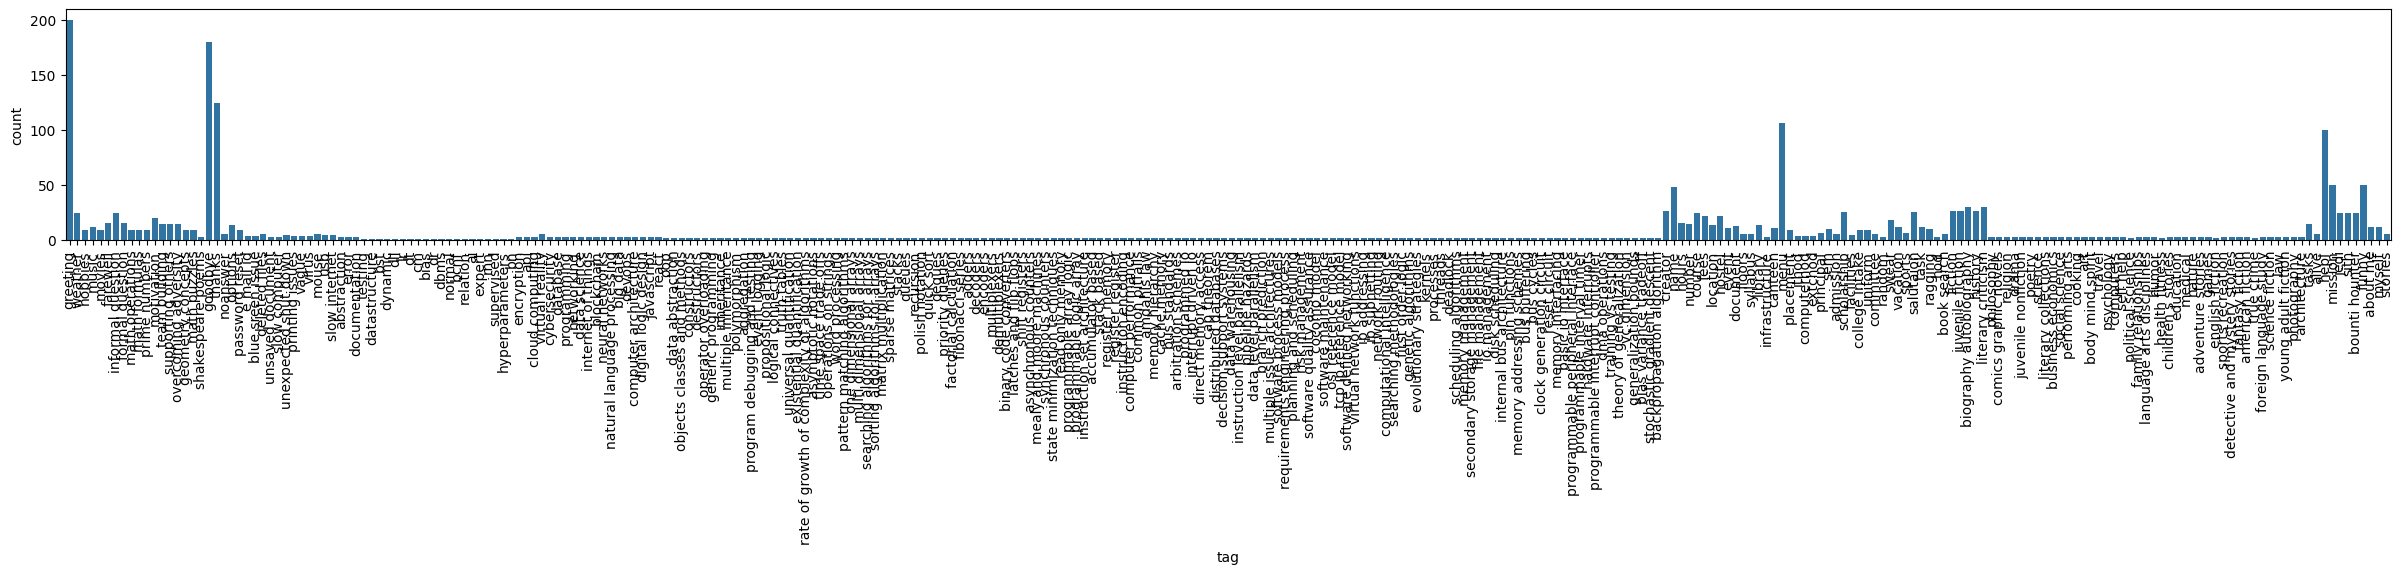

In [78]:
plt.figure(figsize=(30,3))
plt.xticks(rotation =90)
sns.countplot(data=df, x='tag')

Data is highly unbalance

# Before Training

X-Y

In [79]:
corpus = QA_df['pattern']
labels = QA_df['tag']

Encoding

In [80]:
le = LabelEncoder()
le.fit(labels)
labels_encoded = le.transform(labels)

Tokenization & Padding

In [81]:
MAX_LEN = 12

In [82]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
sequences = tokenizer.texts_to_sequences(corpus)

In [83]:
padded_sequences = pad_sequences(sequences, padding='post', maxlen=MAX_LEN)

In [84]:
padded_sequences.shape

(1108, 12)

# Model

In [85]:
model = Sequential(
    [
        Embedding(input_dim= len(tokenizer.word_index) + 1 ,output_dim = 8, input_length= MAX_LEN),
        LSTM(units= 64, return_sequences=True),
        LSTM(units= 64, return_sequences=False),
        Dense(units=32, activation='relu'),
        Dense(units=16, activation='relu'),
        Dense(units= len(set(labels_encoded)) , activation = 'softmax')
    ]
)

c:\Users\yosef\anaconda3\envs\my-env\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [86]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [87]:
model.build(padded_sequences.shape)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (1108, 12, 8)          │         6,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (1108, 12, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (1108, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (1108, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (1108, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1108, 300)            │         5,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,052 (258.02 KB)

 Trainable params: 66,052 (258.02 KB)

 Non-trainable params: 0 (0.00 B)

In [88]:
model.fit(padded_sequences,labels_encoded, epochs=500)

Epoch 1/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 5.7008
Epoch 2/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.5957
Epoch 3/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.2898
Epoch 4/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.9734
Epoch 5/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.9007
Epoch 6/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.8212
Epoch 7/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.7323
Epoch 8/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6947
Epoch 9/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5958
Epoch 10/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.6286
Epoch 11/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4790
Epoch 12/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.4763
Epoch 13/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3769
Epoch 14/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.3186
Epoch 15/500
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1895
Epoc

# Exporting

In [89]:
object_cache.saveObject(tokenizer,'tokenizer')
object_cache.saveObject(le,'le')
object_cache.saveObject(tags_answers,'tags_answers')
model.save('cache/chatbot_model.h5')

Object successfully saved to cache\tokenizer.pickle
Object successfully saved to cache\le.pickle
Object successfully saved to cache\tags_answers.pickle
